In [7]:
import os
import photutils
import webbpsf
import matplotlib.pyplot as plt
os.environ['WEBBPSF_PATH'] = './webbpsf-data'
# For an example observation
# Example image: NIRCam LW F356W observation 
file = 'jw02725-o484_t097_nircam_clear-f356w-nrcalong_wfscmb-04.fits'

In [8]:
from astropy.io import fits
from photutils.background import Background2D, MedianBackground
from astropy.stats import SigmaClip
from photutils.detection import IRAFStarFinder
from photutils.background import MMMBackground
from photutils.background import MADStdBackgroundRMS
psf = fits.open(file) # Open the file
data = psf['SCI'].data # read in the science data
mask = (psf['DQ'].data % 2).astype('bool') # and the data quality mask
sigma_clip = SigmaClip(sigma=3.0) # we'll filter out data beyond 3 standard deviations
bkg_est1 = MedianBackground() # we will try out try different background types to compare
bkg_est2 = MMMBackground()
bkg_est3 = MADStdBackgroundRMS()
bkg1 = Background2D(data, (50,50), filter_size=(3,3), sigma_clip=sigma_clip, bkg_estimator=bkg_est1, mask=mask)
bkg2 = Background2D(data, (50,50), filter_size=(3,3), sigma_clip=sigma_clip, bkg_estimator=bkg_est2, mask=mask)
bkg3 = Background2D(data, (50,50), filter_size=(3,3), sigma_clip=sigma_clip, bkg_estimator=bkg_est3, mask=mask)

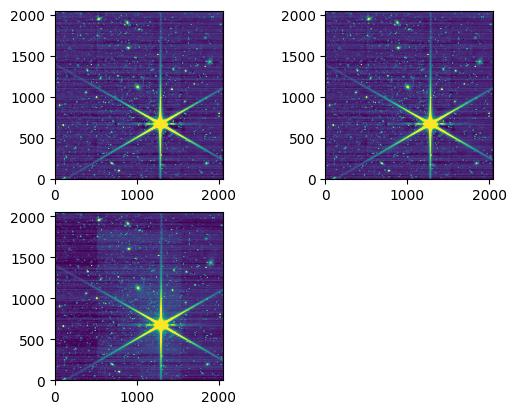

In [9]:
from astropy.visualization import simple_norm
ax1 = plt.subplot(2,2,1)
norm1 = simple_norm(data - bkg1.background, 'asinh', min_percent=20, max_percent=98.99)
ax1.imshow(data - bkg1.background, norm=norm1, origin='lower')
ax2 = plt.subplot(2,2,2)
norm2 = simple_norm(data - bkg2.background, 'asinh', min_percent=20, max_percent=98.99)
ax2.imshow(data - bkg2.background, norm=norm2, origin='lower')
ax3 = plt.subplot(2,2,3)
norm3 = simple_norm(data - bkg3.background, 'asinh', min_percent=20, max_percent=98.99)
ax3.imshow(data - bkg3.background, norm=norm3, origin='lower')

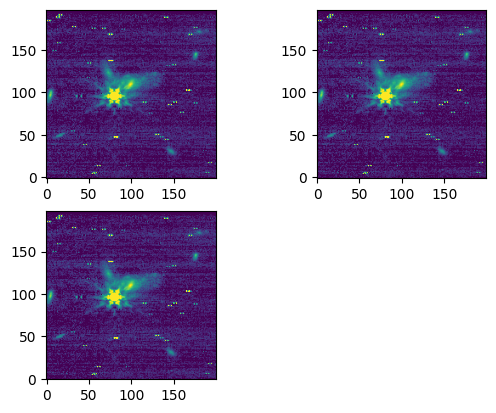

In [10]:
# We extract a subarray around a point of interest
from astropy.nddata import Cutout2D
position = (550, 1950)
size_pixels = 200
ax1 = plt.subplot(2,2,1)
data_source1 = Cutout2D(data - bkg1.background, position, size_pixels).data
norm1 = simple_norm(data_source1, 'asinh', min_percent=20, max_percent=99.6)
ax1.imshow(data_source1, norm=norm1, origin='lower')
ax2 = plt.subplot(2,2,2)
data_source2 = Cutout2D(data - bkg2.background, position, size_pixels).data
norm2 = simple_norm(data_source2, 'asinh', min_percent=20, max_percent=99.6)
ax2.imshow(data_source2, norm=norm2, origin='lower')
ax3 = plt.subplot(2,2,3)
data_source3 = Cutout2D(data - bkg3.background, position, size_pixels).data
norm3 = simple_norm(data_source3, 'asinh', min_percent=20, max_percent=99.6)
ax3.imshow(data_source3, norm=norm3, origin='lower')

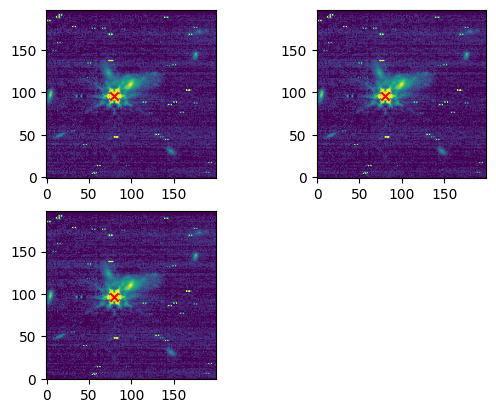

In [11]:
# We find the location of our bright psf
starfind1 = IRAFStarFinder(fwhm=3.0, threshold=100.*bkg1.background_median)
starfind2 = IRAFStarFinder(fwhm=3.0, threshold=100.*bkg2.background_median)
starfind3 = IRAFStarFinder(fwhm=3.0, threshold=100.*bkg3.background_median)
sources1=starfind1(data_source1)
sources2=starfind2(data_source2)
sources3=starfind3(data_source3)
ax1 = plt.subplot(2,2,1)
ax1.imshow(data_source1, norm=norm1, origin='lower')
ax1.scatter(sources1['xcentroid'], sources1['ycentroid'], color='red', marker='x')
ax2 = plt.subplot(2,2,2)
ax2.imshow(data_source2, norm=norm2, origin='lower')
ax2.scatter(sources2['xcentroid'], sources2['ycentroid'], color='red', marker='x')
ax3 = plt.subplot(2,2,3)
ax3.imshow(data_source3, norm=norm3, origin='lower')
ax3.scatter(sources3['xcentroid'], sources3['ycentroid'], color='red', marker='x')

(530.024178293244, 1946.067039647067)
(530.0241780129078, 1946.0670407356938)
(530.0241783493506, 1946.0670400564238)


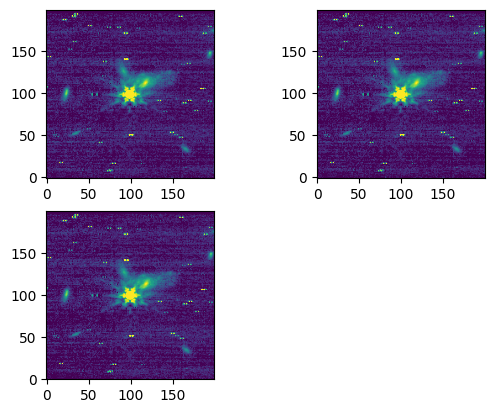

In [12]:
# and recenter our cutout image around the psf
positions_original1 = Cutout2D(data - bkg1.background, position, size_pixels).to_original_position((sources1['xcentroid'],sources1['ycentroid']))
position1 = (positions_original1[0].value[0], positions_original1[1].value[0])
positions_original2 = Cutout2D(data - bkg2.background, position, size_pixels).to_original_position((sources2['xcentroid'],sources2['ycentroid']))
position2 = (positions_original2[0].value[0], positions_original2[1].value[0])
positions_original3 = Cutout2D(data - bkg3.background, position, size_pixels).to_original_position((sources3['xcentroid'],sources3['ycentroid']))
position3 = (positions_original3[0].value[0], positions_original3[1].value[0])
size = 200
ax1 = plt.subplot(2,2,1)
data_source1 = Cutout2D(data - bkg1.background, position1, size_pixels).data
norm1 = simple_norm(data_source1, 'asinh', min_percent=20, max_percent=99.6)
ax1.imshow(data_source1, norm=norm1, origin='lower')
ax2 = plt.subplot(2,2,2)
data_source2 = Cutout2D(data - bkg2.background, position2, size_pixels).data
norm2 = simple_norm(data_source2, 'asinh', min_percent=20, max_percent=99.6)
ax2.imshow(data_source2, norm=norm2, origin='lower')
ax3 = plt.subplot(2,2,3)
data_source3 = Cutout2D(data - bkg3.background, position3, size_pixels).data
norm3 = simple_norm(data_source3, 'asinh', min_percent=20, max_percent=99.6)
ax3.imshow(data_source3, norm=norm3, origin='lower')
print(position1)
print(position2)
print(position3)

In [13]:
# we generate a webpsf simulation to match the jwst observation
inst1 = webbpsf.setup_sim_to_match_file(file)
inst2 = webbpsf.setup_sim_to_match_file(file)
inst3 = webbpsf.setup_sim_to_match_file(file)
inst1.detector_position = position1
inst2.detector_position = position2
inst3.detector_position = position3
single_webbpsf_nrc1 = inst1.calc_psf(fov_pixels=size_pixels)
single_webbpsf_nrc2 = inst2.calc_psf(fov_pixels=size_pixels)
single_webbpsf_nrc3 = inst3.calc_psf(fov_pixels=size_pixels)

Setting up sim to match jw02725-o484_t097_nircam_clear-f356w-nrcalong_wfscmb-04.fits
iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-11-29T17:26:06.893
                        MJD: 59912.72646866898

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022112903-NRCA3_FP1-1.fits
	Date (MJD):	 59912.7265
	Delta time:	 -0.0000 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022120203-NRCA3_FP1-1.fits
	Date (MJD):	 59915.1683
	Delta time:	 2.4418 days
User requested choosing OPD time closest in time to 2022-11-29T17:26:06.893, which is R2022112903-NRCA3_FP1-1.fits, delta time -0.000 days
Importing and format-converting OPD from /Users/liz/Desktop/photometry/webbpsf-data/MAST_JWST_WSS_OPDs/R2022112903-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F356W
    Detector: NRCA5
    Apername: NRCA5_FULL
    Det. Pos.

In [14]:
# we take the output simulated psf and convert it into a photutils fittable model
webbpsf_model1 = photutils.psf.FittableImageModel(single_webbpsf_nrc1['DET_DIST'].data, normalize=True, oversampling=1)
webbpsf_model2 = photutils.psf.FittableImageModel(single_webbpsf_nrc2['DET_DIST'].data, normalize=True, oversampling=1)
webbpsf_model3 = photutils.psf.FittableImageModel(single_webbpsf_nrc3['DET_DIST'].data, normalize=True, oversampling=1)

In [15]:
# and perform the photometry
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry
fit_shape = (5,5)
psfphot1 = PSFPhotometry(webbpsf_model1, fit_shape, finder=starfind1, aperture_radius=4)
psfphot2 = PSFPhotometry(webbpsf_model2, fit_shape, finder=starfind2, aperture_radius=4)
psfphot3 = PSFPhotometry(webbpsf_model3, fit_shape, finder=starfind3, aperture_radius=4)
phot1 = psfphot1(data_source1)
phot2 = psfphot2(data_source2)
phot3 = psfphot3(data_source3)
print(phot1)
print(phot2)
print(phot3)

 id group_id local_bkg      x_init          y_init         flux_init      ... npixfit group_size         qfit                 cfit         flags
--- -------- --------- --------------- --------------- ------------------ ... ------- ---------- ------------------- --------------------- -----
  1        1       0.0 99.024178293244 99.067039647067 3328.1781920824656 ...      25          1 0.08165903959837509 -0.012449800305233136     0
 id group_id local_bkg       x_init            y_init          flux_init      ... npixfit group_size         qfit                 cfit         flags
--- -------- --------- ----------------- ----------------- ------------------ ... ------- ---------- ------------------- --------------------- -----
  1        1       0.0 99.02417801290783 99.06704073569374 3328.9446835800422 ...      25          1 0.08172500498009685 -0.012452939784129115     0
 id group_id local_bkg       x_init            y_init          flux_init     ... npixfit group_size         qfit      

In [16]:
# we also create a residual image 
residual1 = psfphot1.make_residual_image(data_source1, (size_pixels,size_pixels))
residual2 = psfphot2.make_residual_image(data_source2, (size_pixels,size_pixels))
residual3 = psfphot3.make_residual_image(data_source3, (size_pixels,size_pixels))

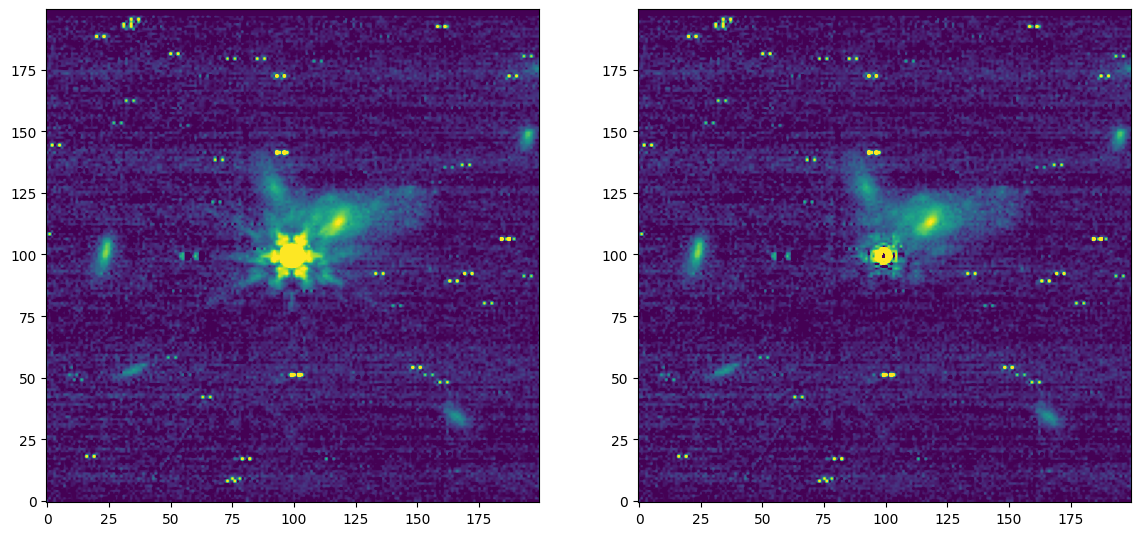

In [17]:
plt.figure(figsize=(14,16))
plt.subplot(1,2,1)
plt.imshow(data_source1, norm=norm1, origin='lower')
plt.subplot(1,2,2)
plt.imshow(residual1, norm=norm1, origin='lower')

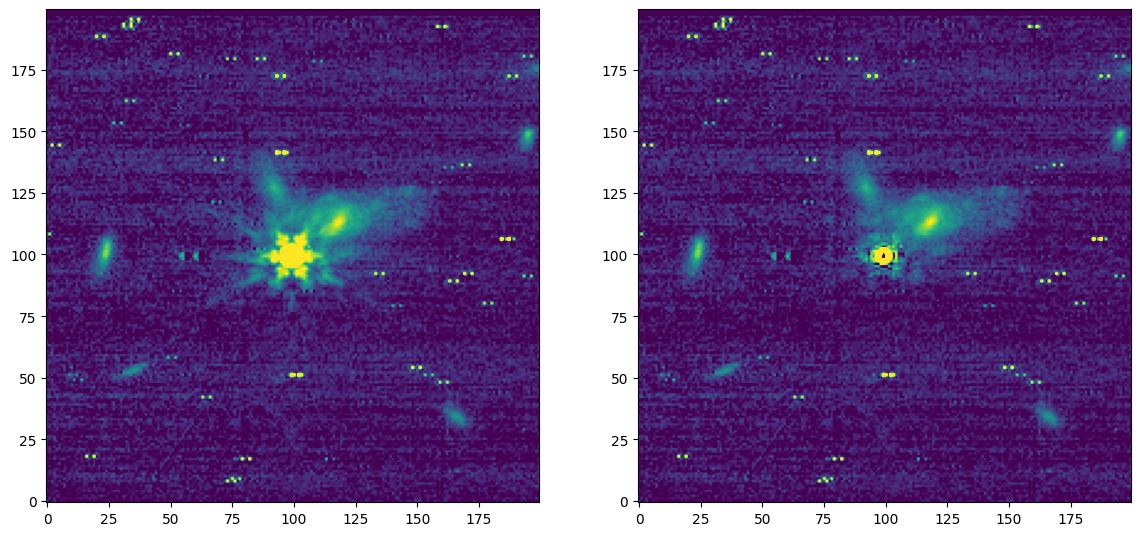

In [18]:
plt.figure(figsize=(14,16))
plt.subplot(1,2,1)
plt.imshow(data_source2, norm=norm2, origin='lower')
plt.subplot(1,2,2)
plt.imshow(residual2, norm=norm2, origin='lower')

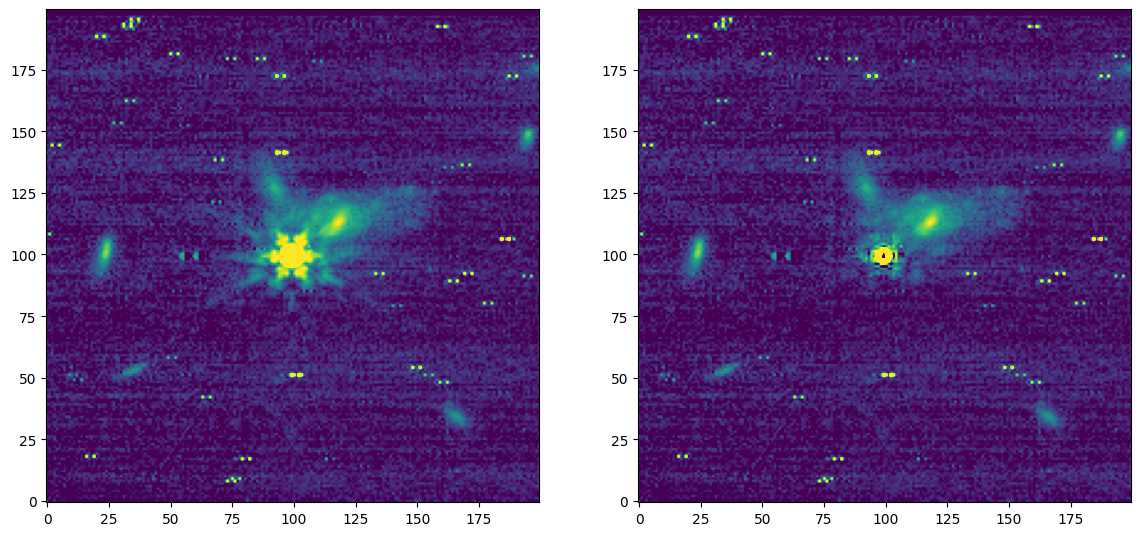

In [19]:
plt.figure(figsize=(14,16))
plt.subplot(1,2,1)
plt.imshow(data_source3, norm=norm3, origin='lower')
plt.subplot(1,2,2)
plt.imshow(residual3, norm=norm3, origin='lower')